In [2]:
# NumPy and odeint, our workhorses
import numpy as np
import scipy.stats as st
import numba

# Plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# Line profiler (you might not have this installed)
#%load_ext line_profiler

# This is to enable inline displays for the purposes of the tutorial
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

In [4]:
# Column 0 is change in m, column 1 is change in p
"""
Here we introduce de S matrix where all reactions(rows) and metabolites(columns) will be described.
"""
simple_update = np.array([[1, 0],
                          [-1, 0],
                          [0, 1],
                          [0, -1]], dtype=np.int)


In [5]:
def simple_propensity(params, population):
    """
    Returns an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack parameters
    beta_m, beta_p, gamma = params
    
    # Unpack population
    m, p = population
    
    return np.array([beta_m, 
                     m, 
                     beta_p * m, 
                     gamma * p])

In [7]:
def sample_discrete(probs):
    """
    Randomly sample an index with probability given by probs.
    """
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

In [9]:
# Function to draw time interval and choice of reaction
def gillespie_draw(params, propensity_func, population):
    """
    Draws a reaction and the time it took to do that reaction.
    """
    # Compute propensities
    props = propensity_func(params, population)
    
    # Sum of propensities
    props_sum = props.sum()
    
    # Compute time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = props / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time

In [10]:
def gillespie_ssa(params, propensity_func, update, population_0, 
                  time_points):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from proability distribution of particle counts over time.
    
    Parameters
    ----------
    params : arbitrary
        The set of parameters to be passed to propensity_func.
    propensity_func : function
        Function of the form f(params, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
        
    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=np.int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(params, propensity_func, population)
                
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out

In [11]:
# Specify parameters for calculation
params = np.array([10, 10, 0.4])
time_points = np.linspace(0, 50, 101)
population_0 = np.array([0, 0])
n_simulations = 100

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
pops = np.empty((n_simulations, len(time_points), 2))

# Run the calculations
for i in range(n_simulations):
    pops[i,:,:] = gillespie_ssa(params, simple_propensity, simple_update,
                                population_0, time_points)

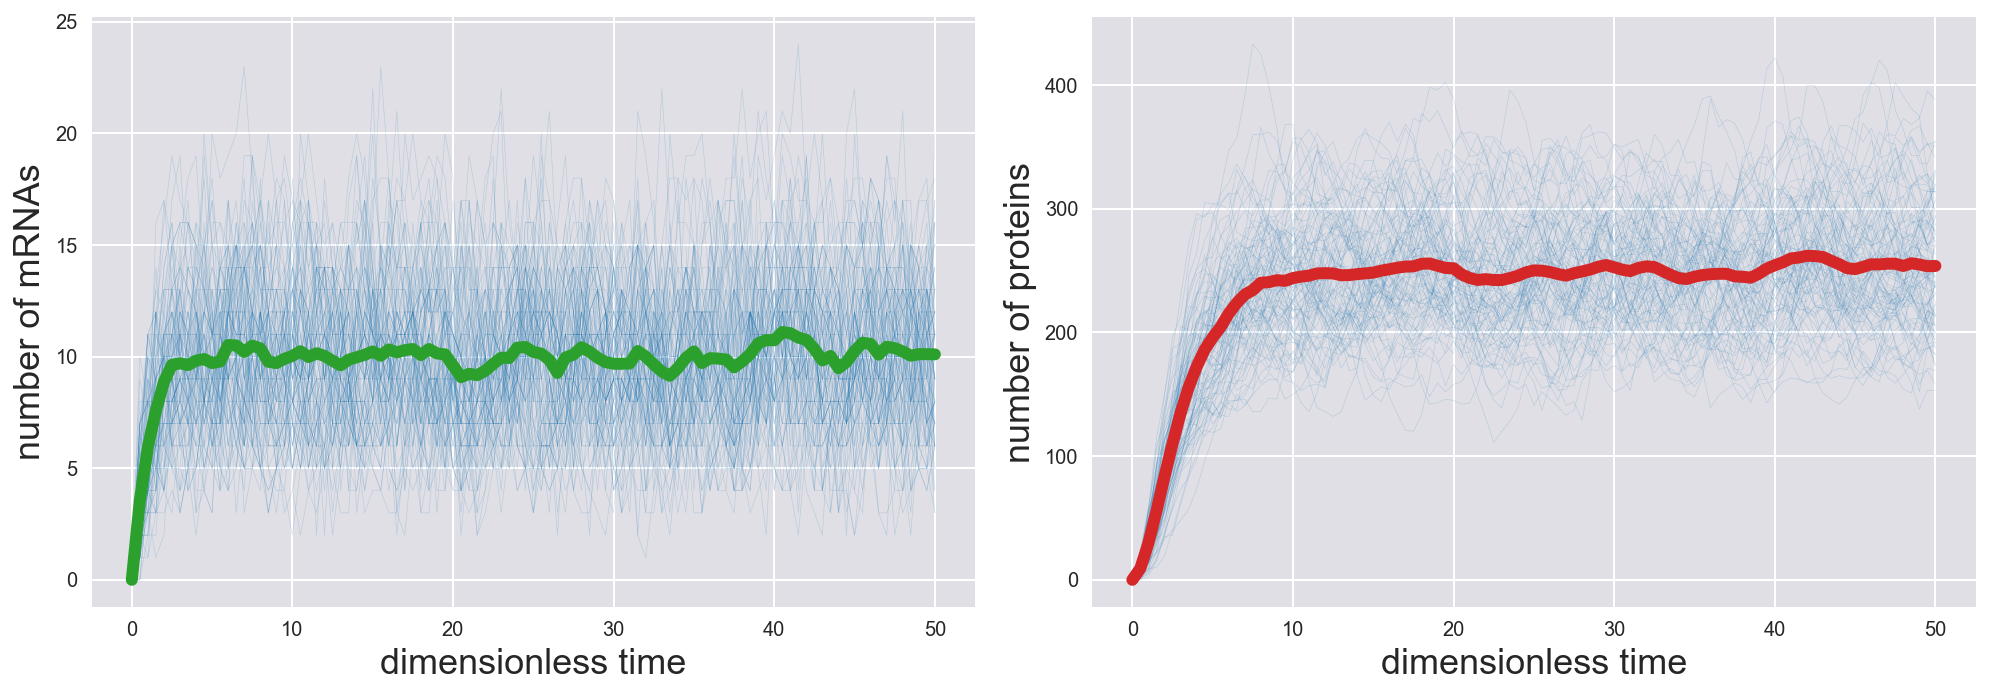

In [13]:
# Set up subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot mRNA trajectories
for i in range(n_simulations):
    ax[0].plot(time_points, pops[i,:,0], '-', lw=0.3, alpha=0.2, 
               color=sns.color_palette()[0])

# Plot mRNA mean
ax[0].plot(time_points, pops[:,:,0].mean(axis=0), '-', lw=6, 
           color=sns.color_palette()[2])

# Plot protein trajectories
for i in range(n_simulations):
    ax[1].plot(time_points, pops[i,:,1], 'k-', lw=0.3, alpha=0.2,
               color=sns.color_palette()[0])

# Plot protein mean
ax[1].plot(time_points, pops[:,:,1].mean(axis=0), 'r-', lw=6, 
           color=sns.color_palette()[3])

# Label axes
ax[0].set_xlabel('dimensionless time')
ax[1].set_xlabel('dimensionless time')
ax[0].set_ylabel('number of mRNAs')
ax[1].set_ylabel('number of proteins')
plt.tight_layout()

In [14]:
''''
We can also compute the steady state properties 
by considering the last point in our trace. The last 50 time 
points are at steady state, so we will average over them.
''''
print('mRNA mean copy number =', pops[:,-50:,0].mean())
print('protein mean copy number =', pops[:,-50:,1].mean())
print('mRNA variance =', pops[:,-50:,0].std()**2)
print('protein variance =', pops[:,-50:,1].std()**2)
print('mRNA noise =', pops[:,-50:,0].std() / pops[:,-50:,0].mean())
print('protein noise =', pops[:,-50:,1].std() / pops[:,-50:,1].mean())
print('protein Fano factor =', 
      pops[:,-50:,1].std()**2 / pops[:,-50:,1].mean())
print('mRNA Fano factor =', pops[:,-50:,0].std()**2 / pops[:,-50:,0].mean())
print('protein Fano factor =', 
      pops[:,-50:,1].std()**2 / pops[:,-50:,1].mean())

mRNA mean copy number = 10.0748
protein mean copy number = 251.6994
mRNA variance = 10.26200496
protein variance = 2145.33703964
mRNA noise = 0.317965262817717
protein noise = 0.18402023679851773
protein Fano factor = 8.523409430614455
mRNA Fano factor = 1.018581506332632
protein Fano factor = 8.523409430614455


C:\Users\Vanargand\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Vanargand\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


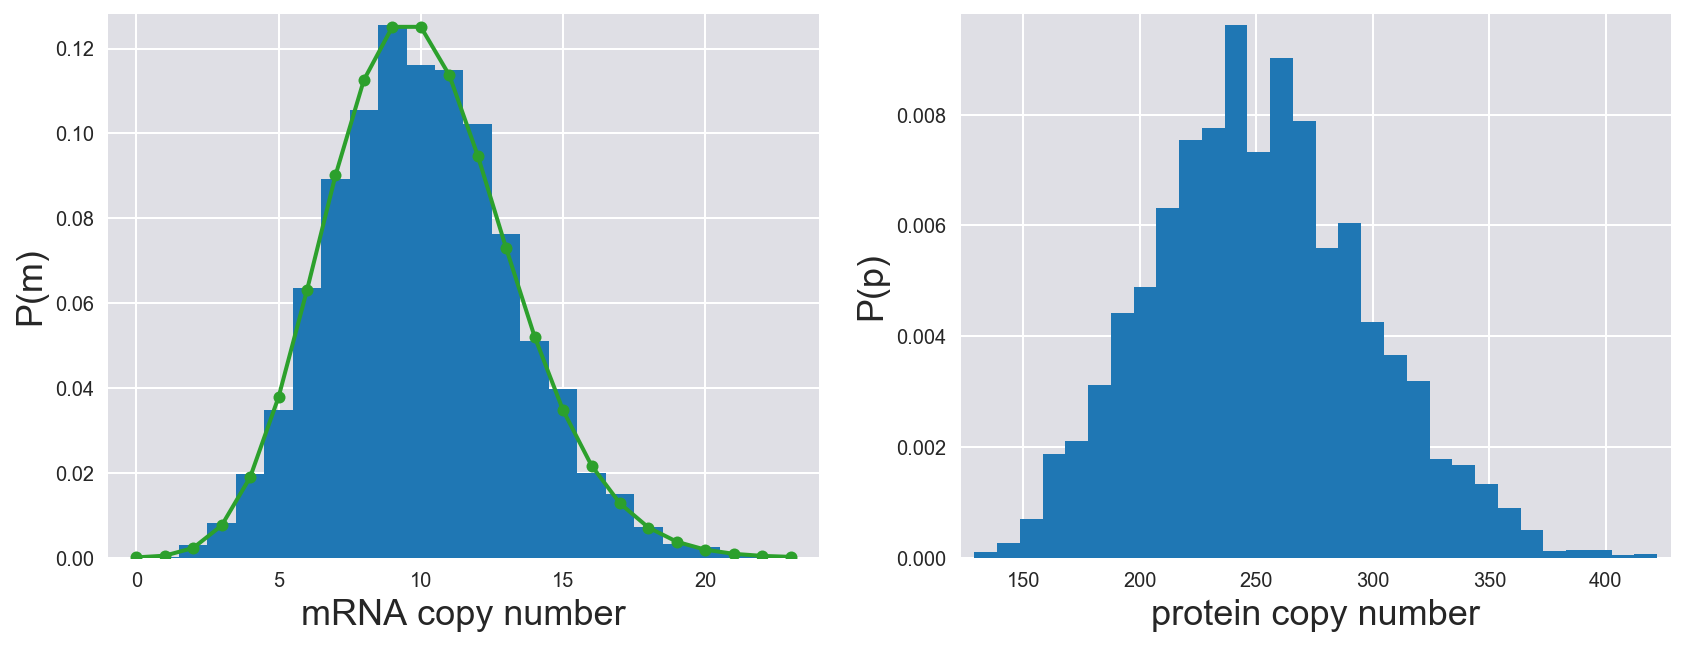

In [15]:
# Set up subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot histogram of mRNA profile with Poisson overlayed
mbins = np.arange(pops[:,-50:,0].max()+1) - 0.5
m = mbins[:-1] + 0.5
ax[0].hist(pops[:,-50:,0].flatten(), mbins, normed=True)
ax[0].plot(m, st.poisson.pmf(m, params[0]), '.-', markersize=12, 
           color=sns.color_palette()[2])
ax[0].set_xlabel('mRNA copy number')
ax[0].set_ylabel('P(m)')
ax[0].margins(0.02)

# Plot histogram of protein profile
ax[1].hist(pops[:,-50:,1].flatten(), bins=30, normed=True)
ax[1].set_xlabel('protein copy number')
ax[1].set_ylabel('P(p)')
ax[1].margins(0.02)

C:\Users\Vanargand\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Vanargand\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


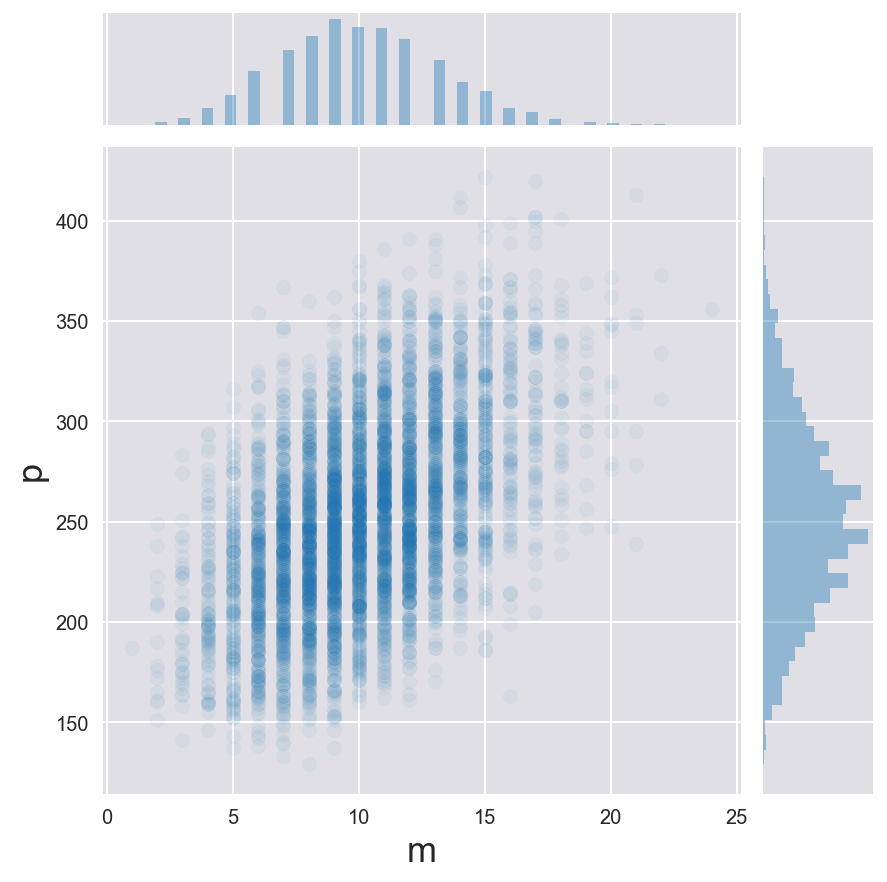

In [16]:
sns.jointplot(pops[:,-50:,0].flatten(), pops[:,-50:,1].flatten(), kind='scatter',
              stat_func=None, alpha=0.05).set_axis_labels('m', 'p')